In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import numpy as np
import torch
from tqdm import trange

from pyhocon.config_parser import ConfigFactory
from rllr.env.vec_wrappers import make_vec_envs
from argparse import ArgumentParser

In [3]:
import sys
sys.path.append('../../experiments/minigrid')

In [4]:
from train_master import gen_env_with_seed

In [5]:
mode = 'master'

if mode == 'master':
    from train_master import gen_env_with_seed
    config = ConfigFactory.parse_file('../../experiments/minigrid/conf/minigrid_second_step.hocon')
    agent_path = '../../experiments/minigrid/artifacts/models/minigrid_master.p'

elif mode == 'ssim_master':
    from train_master import gen_env_with_seed
    config = ConfigFactory.parse_file('../../experiments/minigrid/conf/minigrid_second_step_ssim.hocon')
    agent_path = '../../experiments/minigrid/artifacts/models/minigrid_master_ssim.p'

elif mode == 'ssim_worker':
    from train_worker import gen_env_with_seed
    config = ConfigFactory.parse_file('../../experiments/minigrid/conf/minigrid_first_step_ssim.hocon')
    agent_path = '../../experiments/minigrid/artifacts/models/minigrid_worker_ssim.p'

elif mode == 'worker':
    from train_worker import gen_env_with_seed
    config = ConfigFactory.parse_file('../../experiments/minigrid/conf/minigrid_first_step.hocon')
    agent_path = '../../experiments/minigrid/artifacts/models/minigrid_worker.p'
    
agent = torch.load(agent_path)

In [6]:
import os
if 'worker_agent' in config:
    config['worker_agent']['path'] = os.path.join('../../experiments/minigrid/', config['worker_agent']['path'])

In [7]:
seed = 12
from rllr.env.wrappers import visualisation_wrapper

def gen_monitor_env(env_id, save_video=True):
    env = gen_env_with_seed(config, env_id + seed)
    if save_video:
        env = visualisation_wrapper(env, '../../experiments/minigrid/artifacts/video/')
    return env

env = make_vec_envs(
    lambda env_id: lambda: gen_monitor_env(env_id),
    num_processes=1,
    device='cpu'
)

In [8]:
worker_encoder = env.venv.envs[0].env.env.policy.actor_critic.actor.state_encoder.state_encoder
master_encoder = agent.actor_critic.actor.state_encoder

# Visualize feature maps
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

worker_encoder.conv_net[2].register_forward_hook(get_activation('conv_worker_0'))
worker_encoder.conv_net[-1].register_forward_hook(get_activation('conv_worker_1'))
master_encoder.conv_net[2].register_forward_hook(get_activation('conv_master_0'))
master_encoder.conv_net[-1].register_forward_hook(get_activation('conv_master_1'))

In [9]:
grid_size = 8

def get_position(state):
    nonzero = (state[4:-4, 4:-4].sum(-1)[2::4, 2::4] > 0).nonzero()
    return nonzero[0][0] + 1, nonzero[1][0] + 1

def generate_goal_embeds(worker_goal_state_encoder):
    from rllr.env.gym_minigrid_navigation.environments import gen_wrapped_env

    env = gen_wrapped_env({
        'env_task': 'MiniGrid-Empty',
        'grid_size': 8,
        'action_size': 3,
        'rgb_image': True,
        'tile_size': 4,
    })

    states = [env.reset()]
    for _ in range(grid_size-2):
        for _ in range(grid_size-3):
            state, _, _, _ = env.step(2)
            states.append(state)

        _, _, _, _ = env.step(1)
        _, _, _, _ = env.step(1)
        for _ in range(grid_size-3):
            _, _, _, _ = env.step(2)

        _, _, _, _ = env.step(0)
        state, _, _, _ = env.step(2)
        states.append(state)
        _, _, _, _ = env.step(0)

    states = states[:-1]
    with torch.no_grad():
        embeds = worker_goal_state_encoder(torch.from_numpy(np.stack(states)))
        
    return embeds.reshape(grid_size-2, grid_size-2, -1)

worker_goal_state_encoder = env.venv.envs[0].env.env.policy.actor_critic.actor.state_encoder.goal_state_encoder
embeds = generate_goal_embeds(worker_goal_state_encoder)
embeds.shape

torch.Size([6, 6, 32])

In [10]:
import cv2

def plot_activations(image, obs):
    m = 3

    plt.figure(figsize=(16, 12))

    # observation
    observation = obs.squeeze().numpy() / 255
    
    # worker visualization
    _ = worker_encoder(obs)
    image_worker  = activation['conv_worker_0'].squeeze().sum(0)

    # master visualization
    pdist = torch.nn.CosineSimilarity(dim=-1)
    pdist = torch.nn.PairwiseDistance()
    with torch.no_grad():
        goal = agent.actor_critic.actor(obs).mode().squeeze()

    dists = -1 * pdist(goal, embeds).numpy()
    dists -= dists.min()
    dists /= dists.max()
    
    image_master = np.zeros((grid_size, grid_size))
    image_master[1:-1, 1:-1] = dists

    # plot
    idx = 1
    
    plt.subplot(1, m, idx)
    plt.imshow(image)
    plt.title(f'image')
    plt.axis('off')
    idx += 1

    # plt.subplot(1, m, idx)
    # plt.imshow(observation)
    # plt.title(f'observation')
    # plt.axis('off')
    # idx += 1

    plt.subplot(1, m, idx)
    plt.imshow(image_worker)
    plt.title(f'worker')
    plt.axis('off')
    idx += 1

    plt.subplot(1, m, idx)
    plt.imshow(image_master)
    plt.title(f'master')
    plt.axis('off')
    idx += 1

    plt.show()

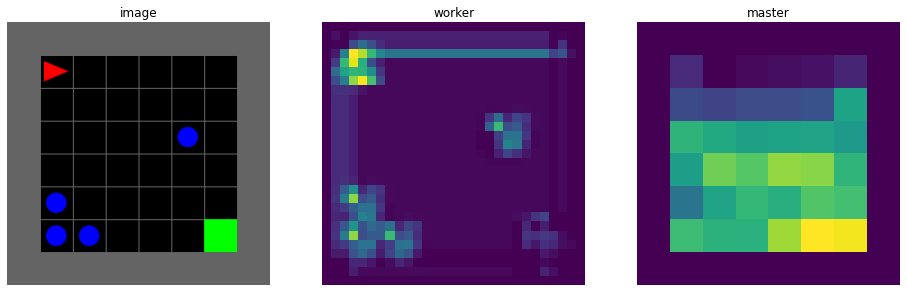

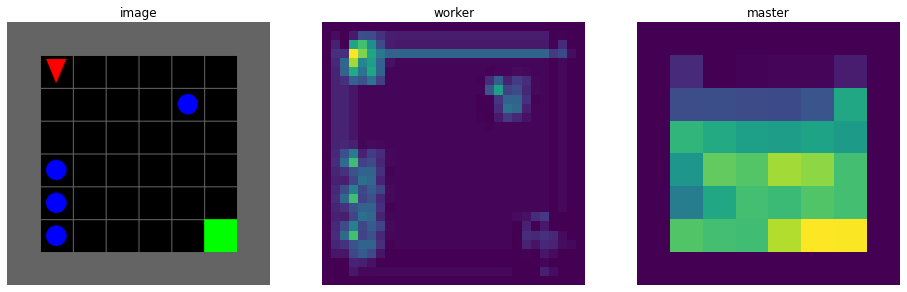

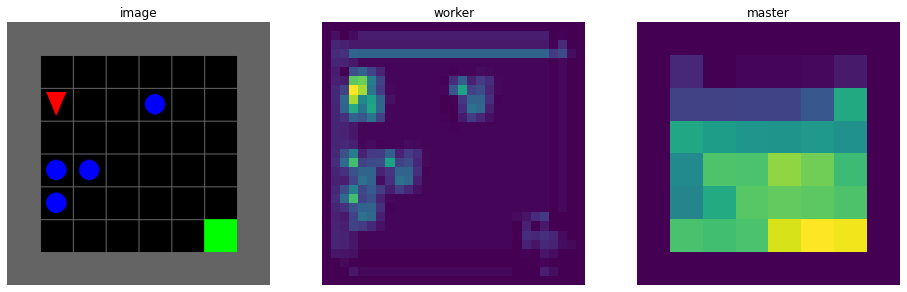

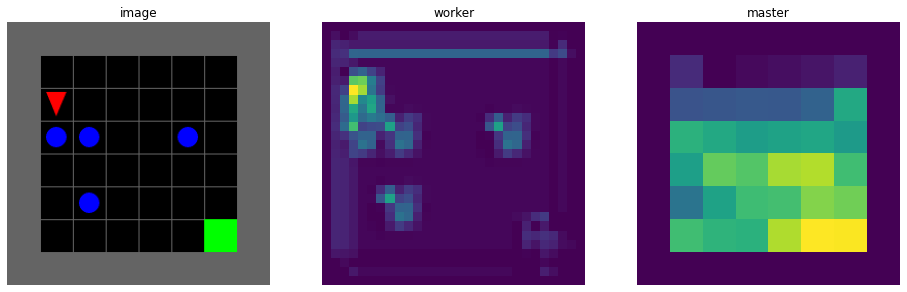

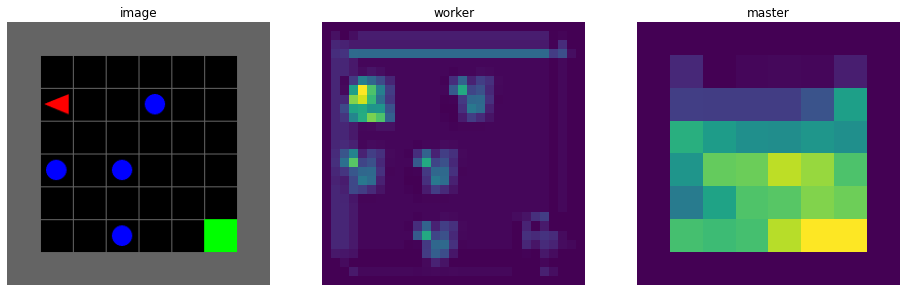

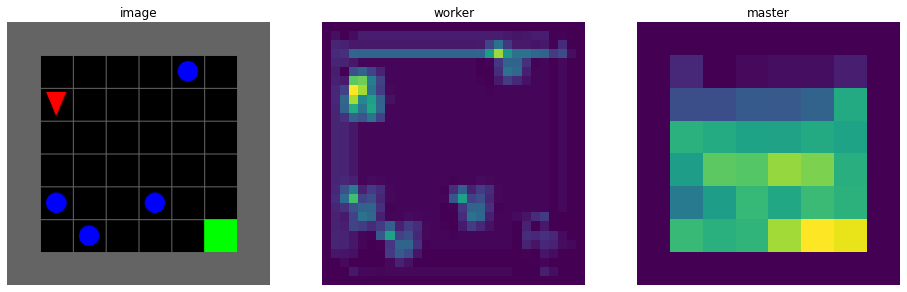

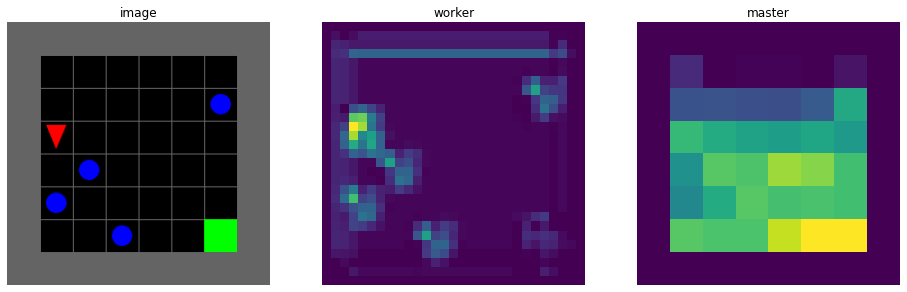

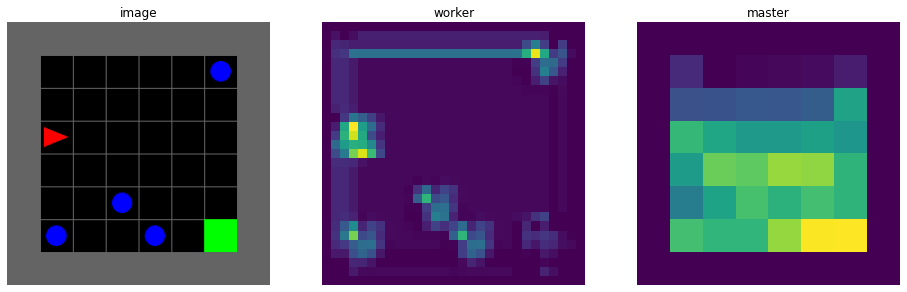

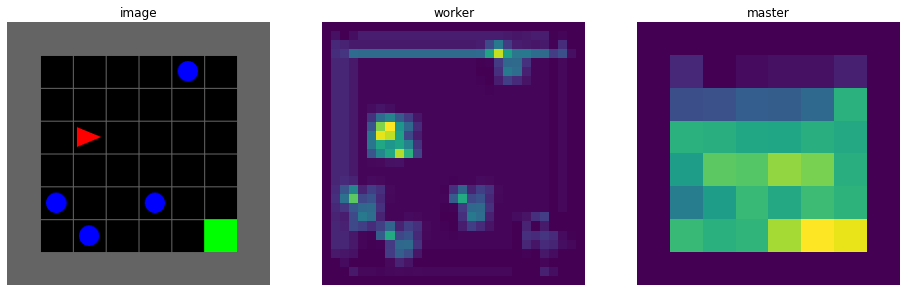

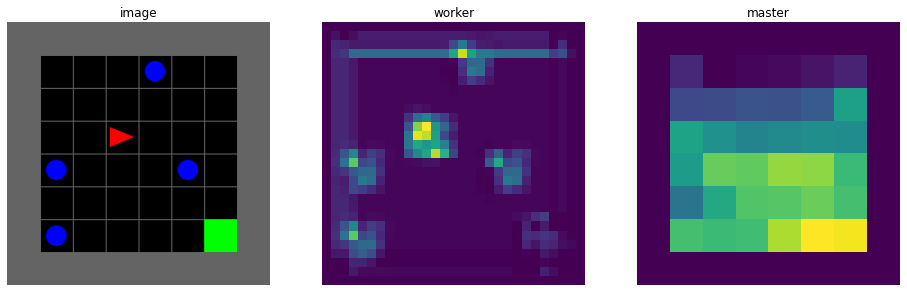

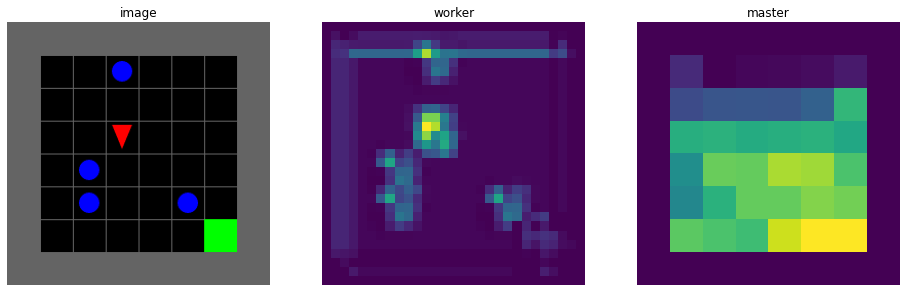

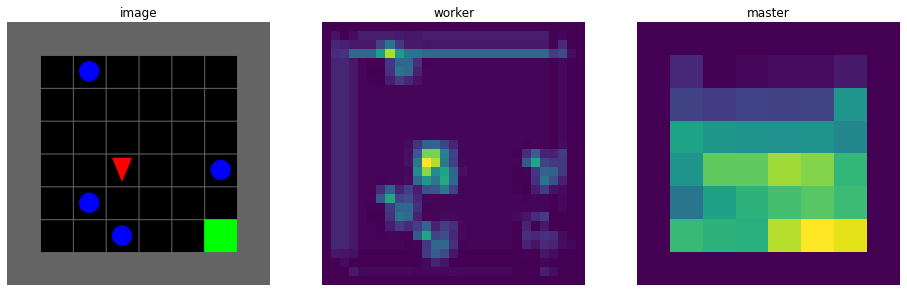

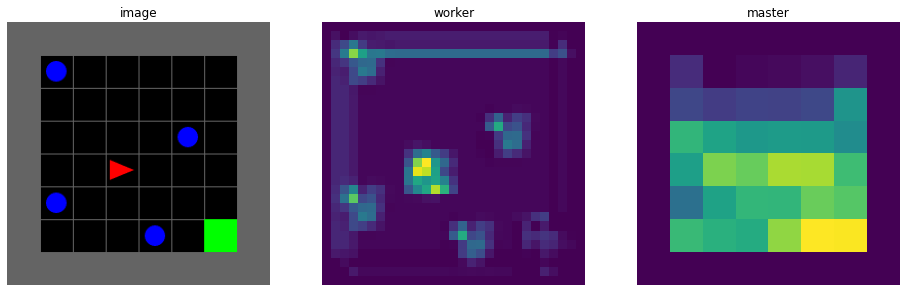

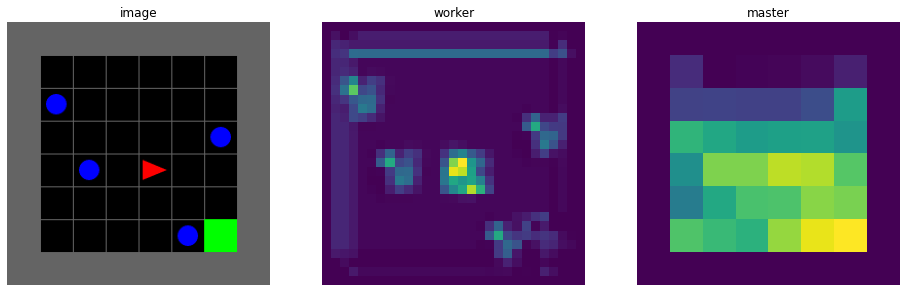

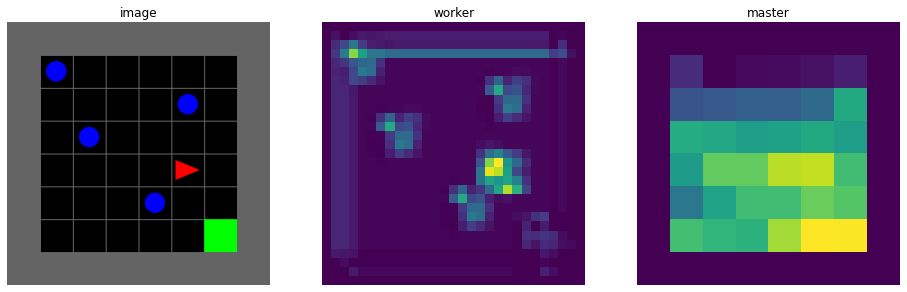

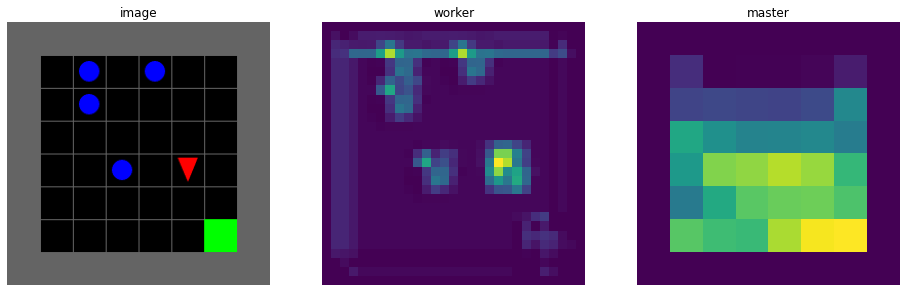

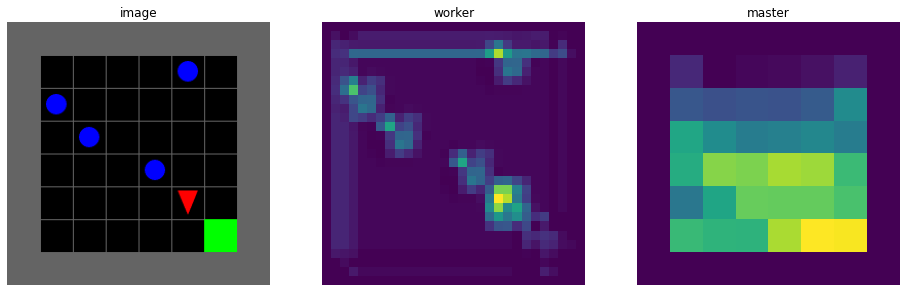

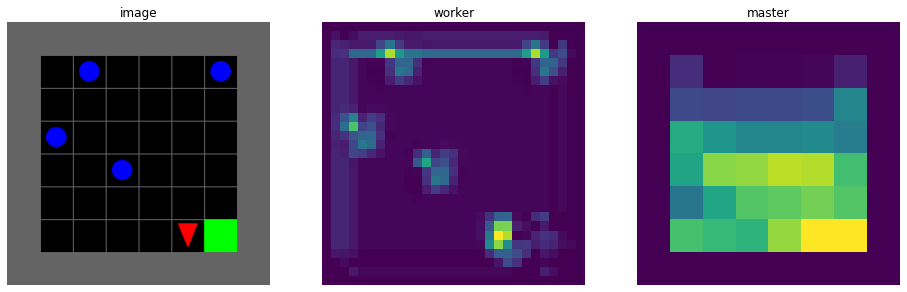

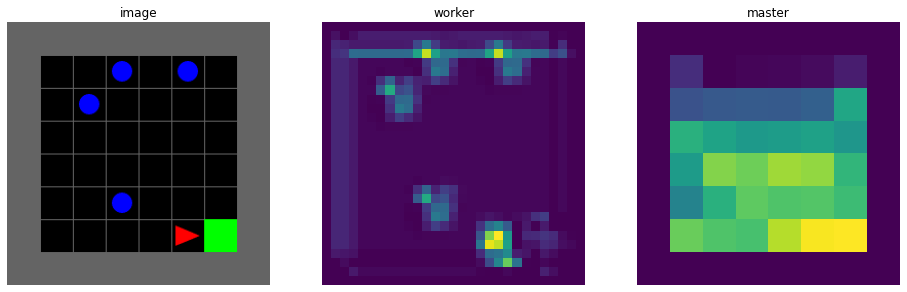

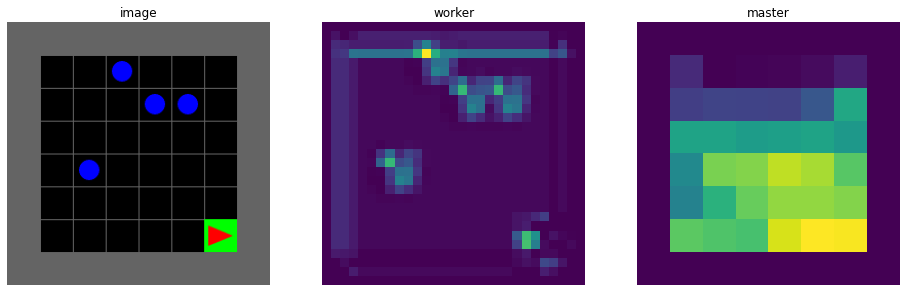

reward: 0.933, steps: 19, success: True


In [11]:
import matplotlib.pyplot as plt

obs, done, episode_reward = env.reset(), False, 0
episode_steps = 0
while not done:
    
    value, action, _ = agent.act(obs, deterministic=True)
    # Obser reward and next obs
    image = env.render('rgb_array')
    plot_activations(image, obs)
        
    obs, reward, done, _ = env.step(action)
    episode_reward += float(reward)
    episode_steps += 1

image = env.render('rgb_array')
plot_activations(image, obs)

print(f'reward: {episode_reward:.3f}, '
      f'steps: {episode_steps}, '
      f'success: {episode_reward>0}'
)

env.close()